Compressible (TALA) 2-D mantle convection problem in a square box
================================================================

We next highlight the ease at which simulations can be updated to
incorporate more realistic physical approximations. We first account
for compressibility, under the Truncated Anelastic Liquid Approximation (TALA),
simulating a well-established 2-D benchmark case from King et al. (2010).
Boundary conditions and material properties are otherwise identical to the
previous tutorial.

Governing equations
-------------------

Density changes across Earth's mantle result primarily from hydrostatic compression,
with density increasing by $\approx 65\%$ from surface to core-mantle-boundary (CMB).
Variations in density associated with local temperature and pressure perturbations are
small in comparison to the spherically averaged density. For a chemically homogeneous
mantle, it is therefore appropriate to assume a linearised equation of state, of the form:

$$ \rho = \bar \rho(\bar T, \bar p) + \rho', $$

which can be further expanded as follows:

$$ \rho = \bar \rho(\bar T, \bar p) + \bar \rho (\bar \chi_{_T} p' - \bar \alpha  T'). $$

Here $\rho$, $p$, $T$, $\chi_{_T}$ and $\alpha$ denote density, pressure, temperature,
isothermal compressibility and the coefficient of thermal expansion, respectively,
whilst overbars refer to a reference state and primes to departures from it:

$$ T = \bar T + T', \quad \quad p = \bar p + p'. $$

It is convenient to take the reference state as motionless and steady. Accordingly, for
the purposes of the compressible case examined here, we will assume that the reference
state varies as a function of depth, $z$, only. The reference state pressure thus satisfies
the hydrostatic approximation:

$$ \frac{\partial \bar p}{\partial z} = \bar \rho \bar \bf{g} \cdot \hat{\vec{k}}, $$

where $\mathbf{g}$ is the acceleration of gravity and $\hat{\vec{k}}$ is the unit vector in
the direction opposite to gravity. On Earth, $\mathbf{g}$ is a function of position, however,
for simplicity, it will be assumed constant here. Following
King et al. (2010), the reference density and reference temperature are described through an
adiabatic Adams-Williamson equation of state, where:

$$ \bar \rho(z) = \rho_{0}  \;  \mbox{exp} \Bigl (\frac{\alpha_{0} g_{0}}{\gamma_{0}c_{p_{0}}} z \Bigr ) $$

and:

$$ \bar T(z) = T_{s}  \;  \mbox{exp} \Bigl (\frac{\alpha_{0} g_{0}}{c_{p_{0}}} z \Bigr ). $$

Here, $c_p$ and $T_{s}$ represent the specific heat capacity at constant pressure and surface temperature,
respectively, whilst $\gamma_{0}$ denotes the Gruneisen parameter, given by:
$$ \gamma_{0} = \frac{\alpha_{0}}{\rho_{0} c_{v_{0}} \chi_{_{T_0}} }, $$

where $c_{v}$ denotes the specific heat capacity at constant volume. Variables with a sub-script $0$ are constants,
used in defining the reference state. Here, they are defined at the domain's upper surface.

Assuming a linearised equation of state, the dimensionless form of the conservation of mass equation under the
Anelastic Liquid Approximation (ALA) can be expressed as:

$$ \nabla \cdot (\bar \rho \mathbf{u}) = 0,$$

where $\mathbf{u}$ is the velocity. Neglecting inertial terms, the force balance equation becomes:

$$ \mathbf{\nabla} \cdot \left[ \mu \left(\nabla \mathbf{u} + \nabla \mathbf{u}^{T} - \frac{2}{3} \nabla \cdot \mathbf{u} \, \mathbf I \right) \right] -  \nabla p' - Ra \bar \rho \hat{\vec{k}} \bar \alpha T' - \frac{Di}{\gamma_0} \frac{c_{p_{0}}}{c_{v_{0}}} \bar \rho \hat{\vec{k}} \bar \chi_{_T} p' = 0, $$

where $\mu$ denotes the dynamic viscosity, $\mathbf I$ the identity tensor, $Ra$ the Rayleigh number, and $Di$ the dissipation number given by, respectively:

$$ Ra = \frac{\rho_{0} \alpha_{0} \Delta T g_{0} d^{3}}{\mu_{0} \kappa_{0}}; \;  \quad Di = \frac{\alpha_{0} g_{0}d}{c_{p_{0}}}, $$

with $\kappa$ denoting the thermal diffusivity, $d$ the length scale and $\Delta T$ the temperature scale. Note that the last
but one term in the force-balance equation above is expressed in terms of the temperature perturbation, $T'$.
Finally, in the absence of internal heating, conservation of energy is expressed as:

$$ \bar \rho \bar c_{p} \biggl( \frac{\partial T'}{\partial t} + \vec{u}\cdot \nabla T' \biggr) - \nabla \cdot \Bigl [\bar k \nabla (\bar T + T') \Bigr ] + Di \bar \alpha \bar \rho \bar \bf{g} \cdot \mathbf{u} T' - \frac{Di}{Ra}  \Phi = 0, $$

where $k$ is the thermal conductivity and $\Phi$ denotes viscous dissipation. The final two terms represent adiabatic heating and viscous dissipation, respectively.

As can be seen, these equations differ appreciably from the incompressible
approximations utilised in our previous tutorial, with important updates to all
three governing equations. Despite this, the changes required to incorporate these
equations, within UFL and G-ADOPT, are minimal.

This example
------------

In this example, we simulate compressible convection, for an isoviscous material.
It is common practice within the geodynamical modelling community to
neglect dynamic pressure's effect on buoyancy terms in the force-balance equation, under the
so-called Truncated Anelastic Liquid Approximation (TALA). This approximation is used here.

We specify $Ra=10^5$ and a dissipation number $Di=0.5$.
The model is heated from below $ T = 1.0 - (T0*\mbox{exp}(Di) - T0)$, cooled from the top (T=0)
in an enclosed 2-D Cartesian box (i.e. free-slip mechanical boundary
conditions on all boundaries).

As with all examples, the first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

We next set up the mesh, function spaces, and specify functions to hold our solutions,
identically to our previous tutorial.

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)  # Square mesh generated via firedrake
mesh.cartesian = True
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We next specify the important constants for this problem, including those associated with the
compressible reference state. Note that for ease of extension, we specify these as functions,
allowing for spatial variability. The depth-dependent fields considered here are the reference
density and reference temperature, which are a function of the Dissipation number. All other
reference fields are assumed constant at 1 (and, hence, are not specified).

In [3]:
X = SpatialCoordinate(mesh)
Ra = Constant(1e5)  # Rayleigh number
Di = Constant(0.5)  # Dissipation number
T0 = Constant(0.091)  # Non-dimensional surface temperature
rhobar = Function(Q, name="CompRefDensity").interpolate(exp((1.0 - X[1]) * Di))  # Reference density
Tbar = Function(Q, name="CompRefTemperature").interpolate(T0 * exp((1.0 - X[1]) * Di) - T0)  # Reference temperature

These fields are used to set up our Truncated Anelastic Liquid Approximation.

In [4]:
approximation = TruncatedAnelasticLiquidApproximation(Ra, Di, rho=rhobar, Tbar=Tbar)

As with the previous example, we next set up a *Timestep Adaptor*,
for controlling the time-step length (via a CFL
criterion) as the simulation advances in time. For the latter,
we specify the initial time, initial timestep $\Delta t$, and number of
timesteps. Given the low Ra, a steady-state tolerance is also specified,
allowing the simulation to exit when a steady-state has been achieved.
The steady-state tolerance specified here is tight, and can be increased
to speed up the simulation, as required.

In [5]:
time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

We next set up and initialise our Temperature field. Note that here, we take into consideration
the non-dimensional surface temperature, T0. The full temperature field is also initialised.

In [6]:
T = Function(Q, name="Temperature")
T.interpolate((1.0 - (T0*exp(Di) - T0)) * ((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1]))))
FullT = Function(Q, name="FullTemperature").assign(T+Tbar)

This problem has a constant pressure nullspace, handled identically to our
previous tutorial.

In [7]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)

/home/firedrake/firedrake/src/firedrake/firedrake/functionspaceimpl.py:160: FutureWarning: The 'subfunctions' property is deprecated for function spaces, please use the 'subspaces' property instead
  warnings.warn("The 'subfunctions' property is deprecated for function spaces, please use the "


Boundary conditions are next specified.

In [8]:
stokes_bcs = {
    boundary.bottom: {'uy': 0},
    boundary.top: {'uy': 0},
    boundary.left: {'ux': 0},
    boundary.right: {'ux': 0},
}

temp_bcs = {
    boundary.bottom: {'T': 1.0 - (T0*exp(Di) - T0)},
    boundary.top: {'T': 0.0},
}

We next set up our output, in VTK format, including a file
that allows us to visualise the reference state.
We also open a file for logging and calculate our diagnostic outputs.

In [9]:
output_file = VTKFile("output.pvd")
ref_file = VTKFile('reference_state.pvd')
output_frequency = 50

plog = ParameterLog('params.log', mesh)
plog.log_str(
    "timestep time dt maxchange u_rms u_rms_surf ux_max nu_base "
    "nu_top energy avg_t rate_work_g rate_viscous energy_2")

gd = GeodynamicalDiagnostics(z, FullT, boundary.bottom, boundary.top)


We can now setup and solve the variational problem, for both the energy and Stokes equations,
passing in the approximation configured above.

In [10]:
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                             constant_jacobian=True)

Next initiate the time loop, which runs until a steady-state solution has been attained:

In [11]:
for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T, FullT)
        ref_file.write(rhobar, Tbar)

    dt = t_adapt.update_timestep()
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    energy_conservation = abs(abs(gd.Nu_top()) - abs(gd.Nu_bottom()))
    rate_work_against_gravity = assemble(approximation.work_against_gravity(u, T)*dx)
    rate_viscous_dissipation = assemble(approximation.viscous_dissipation(u)*dx)
    energy_conservation_2 = abs(rate_work_against_gravity - rate_viscous_dissipation)

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(delta_t)} {maxchange} "
                 f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(boundary.top)} {gd.Nu_bottom()} "
                 f"{gd.Nu_top()} {energy_conservation} {gd.T_avg()} "
                 f"{rate_work_against_gravity} {rate_viscous_dissipation} "
                 f"{energy_conservation_2}")

    # Calculate Full T
    FullT.assign(T+Tbar)

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [12]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

We can visualise the final temperature field using Firedrake's
built-in plotting functionality.

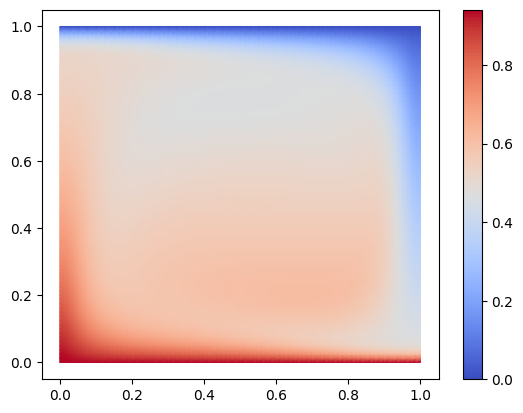

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

The same can be done for the final Full temperature field.

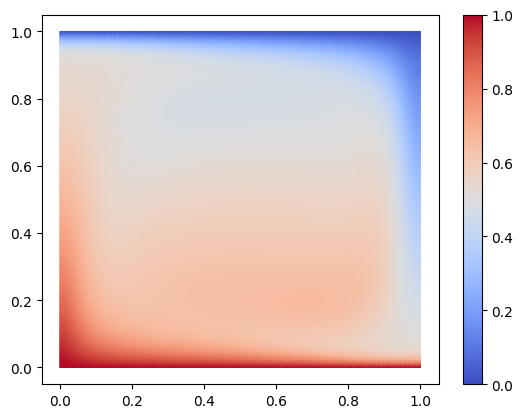

In [14]:
fig, axes = plt.subplots()
collection = tripcolor(FullT, axes=axes, cmap='coolwarm')
fig.colorbar(collection);